

<a target="_blank" href="https://colab.research.google.com/github/USERNAME/REPOSITORY/blob/master/FILENAME.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## The purpos of the notebook is to have the Medgemma model evaluated on "Lung and Colon Cancer Histopathological Images"

Link: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

In [2]:


!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images")

Skipping, found downloaded files in "./lung-and-colon-cancer-histopathological-images" (use force=True to force download)


## We will first use the data set for evaluating the base medgemma model


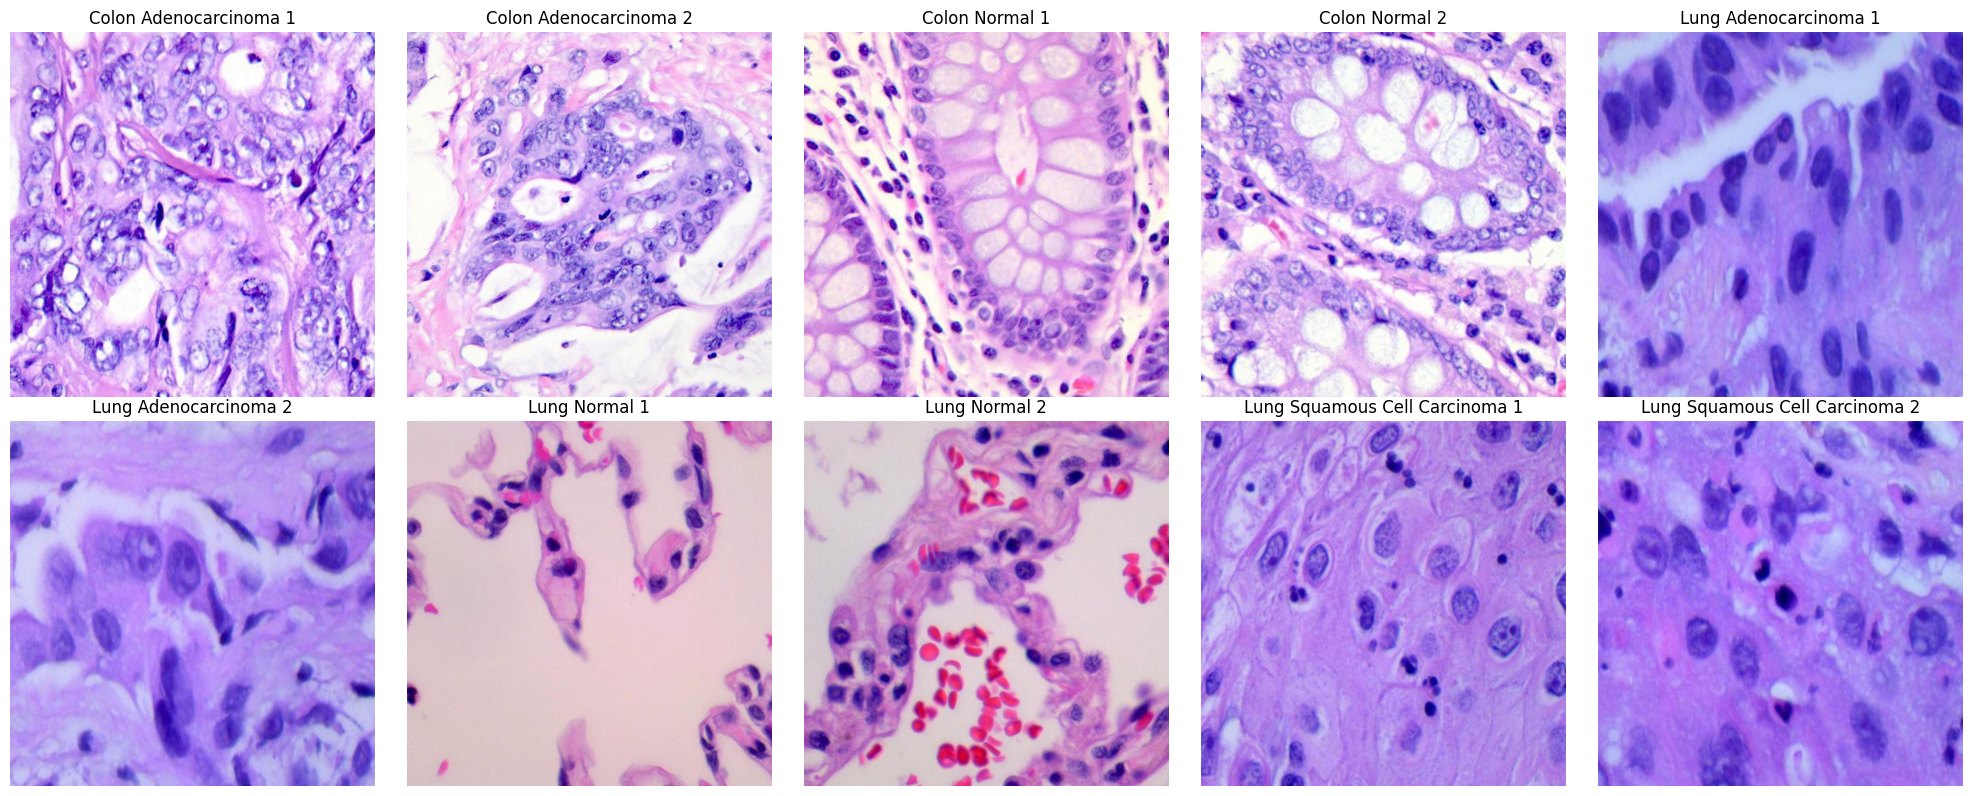

In [7]:

import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Define the base directory
base_dir = "/content/lung-and-colon-cancer-histopathological-images"

# Define the subdirectories and their labels
categories = {
    "lung_colon_image_set/colon_image_sets/colon_aca": "Colon Adenocarcinoma",
    "lung_colon_image_set/colon_image_sets/colon_n": "Colon Normal",
    "lung_colon_image_set/lung_image_sets/lung_aca": "Lung Adenocarcinoma",
    "lung_colon_image_set/lung_image_sets/lung_n": "Lung Normal",
    "lung_colon_image_set/lung_image_sets/lung_scc": "Lung Squamous Cell Carcinoma",
}

# Create a dictionary to store sample image paths for each category
sample_images = {}

# Get 5 random images from each category
for category, label in categories.items():
  category_path = os.path.join(base_dir, category)
  image_files = [os.path.join(category_path, f) for f in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, f))]
  # Ensure we don't try to sample more images than available
  num_samples = min(5, len(image_files))
  sample_images[label] = np.random.choice(image_files, num_samples, replace=False)

# Display 2 samples from each category in a 2x5 subplot
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

i = 0
for label, images in sample_images.items():
  # Display the first 2 images
  for j in range(min(2, len(images))):
    img = mpimg.imread(images[j])
    axes[i].imshow(img)
    axes[i].set_title(f"{label} {j+1}")
    axes[i].axis('off')
    i += 1

# Hide any unused subplots if we have fewer than 10 images total (2 samples * 5 categories)
while i < len(axes):
  axes[i].axis('off')
  i += 1

plt.tight_layout()
plt.show()

## Now that we loaded the samples images we will use this notebook for evaluating the Medgemma model

## Creating a multi option framework for evaluation

In [8]:
from typing import Any

TISSUE_CLASSES = [
    "A: colon_aca",
    "B: colon_n",
    "C: lung_aca",
    "D: lung_n",
    "E: lung_scc"
]

options = "\n".join(TISSUE_CLASSES)
PROMPT = f"What is the most likely tissue type shown in the histopathology image?\n{options}"


def format_data(example: dict[str, Any]) -> dict[str, Any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
        {
            "role": "assistant",
            "content": [
                {
                    "type": "text",
                    "text": TISSUE_CLASSES[example["label"]],
                },
            ],
        },
    ]
    return example


In [9]:


!pip install -q datasets
from datasets import Dataset, DatasetDict, Image

# Create lists to store file paths and corresponding labels
image_paths = []
labels = []
label_mapping = {v: k for k, v in enumerate(categories.values())} # Create a mapping from label string to integer

for category_path_suffix, label in categories.items():
    category_path = os.path.join(base_dir, category_path_suffix)
    for filename in os.listdir(category_path):
        if os.path.isfile(os.path.join(category_path, filename)):
            image_paths.append(os.path.join(category_path, filename))
            labels.append(label_mapping[label])

# Create a dictionary for the dataset
data = {'image': image_paths, 'label': labels}

# Create a Hugging Face Dataset
dataset = Dataset.from_dict(data).cast_column("image", Image())

# Split the dataset into training and validation sets (e.g., 90% train, 10% validation)
train_test_split = dataset.train_test_split(test_size=0.1, seed=42)
dataset_dict = DatasetDict({
    'train': train_test_split['train'],
    'validation': train_test_split['test']
})

print(dataset_dict)

# Apply the format_data function to the dataset
dataset_dict = dataset_dict.map(format_data)

dataset_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 22500
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 2500
    })
})


Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'messages'],
        num_rows: 22500
    })
    validation: Dataset({
        features: ['image', 'label', 'messages'],
        num_rows: 2500
    })
})

In [4]:

dataset_dict["train"][900]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=768x768>,
 'label': 1,
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': 'What is the most likely tissue type shown in the histopathology image?\nA: colon_aca\nB: colon_n\nC: lung_aca\nD: lung_n\nE: lung_scc',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': 'B: colon_n', 'type': 'text'}], 'role': 'assistant'}]}

## We have created a nice procedure for creation of the data

## We will not use Medgemma model to evaluate and we will focus on F1 score. However we will draw conclusion from confusion matrix

## Load model from Hugging face

# Task
Evaluate the performance of the model on the validation dataset using F1 score and confusion matrix.

## Define evaluation metrics

### Subtask:
Set up the F1 score and confusion matrix metrics using libraries like `sklearn`.


**Reasoning**:
Import the necessary metrics from sklearn and define the averaging strategy for F1 score.



In [5]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Define the labels for the confusion matrix
labels = list(label_mapping.keys())

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

print("Evaluation metrics defined: F1 Score and Confusion Matrix")

Evaluation metrics defined: F1 Score and Confusion Matrix


In [14]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoProcessor
from PIL import Image # Import Image to check type

# Assuming 'processor' and 'model' are loaded from the previous steps
# Assuming 'dataset_dict' is available from previous data preparation

def preprocess_eval_data(examples):
    # The 'messages' column is already formatted correctly for the model
    # We just need to ensure the image is in the correct format (PIL Image)
    # and the messages are ready for the processor
    return examples

# We don't need to apply the chat template here, as it's already in the 'messages' column
# The processor will handle the image and text from the 'messages'
def collate_fn(batch):
    # This function will be used by the DataLoader to prepare batches
    # It needs to handle the images and the messages structure
    images = []
    messages = []
    labels = []

    for item in batch:
        # Add a check to ensure the image is a PIL Image before adding
        if 'image' in item and isinstance(item['image'], Image.Image):
             images.append(item['image'])
             messages.append(item['messages'])
             labels.append(item['label'])
        else:
             print(f"Skipping item with invalid or missing image: {item}") # Optional: Log skipped items


    # Process the batch using the model's processor
    # The processor's __call__ method can handle a list of images and text
    # We need to extract the text from the messages for the processor
    # The messages structure is [{'role': 'user', 'content': [{'type': 'image'}, {'type': 'text', 'text': '...'}]}]
    # We need to get the text from the user message content
    # Ensure we only process texts for items where the image was valid and included
    texts = [msg[0]['content'][1]['text'] for msg in messages] # Assuming user message is the first and text is the second content


    # Add print statements to debug the inconsistency
    print(f"Collate function - Number of images: {len(images)}, Number of texts: {len(texts)}")

    # If no valid images are found in a batch, return empty tensors or handle appropriately
    if not images or not texts or len(images) != len(texts):
         print("Warning: Skipping batch due to inconsistent or empty valid images/texts.")
         # Return empty tensors with correct shapes to avoid errors in the next step
         # This might need adjustment based on the expected tensor shapes by the model
         # For simplicity, we can return None or empty dict and handle it in the training loop if needed.
         # However, the dataloader expects tensors. Let's return dummy tensors if empty.
         if not images or not texts:
              return {
                'input_ids': torch.empty(0, dtype=torch.long),
                'attention_mask': torch.empty(0, dtype=torch.long),
                'pixel_values': torch.empty(0), # Shape depends on processor output
                'labels': torch.empty(0, dtype=torch.long)
            }
         else:
             # This case should ideally not happen if the filtering above works
             print("Error: Mismatch after filtering in collate_fn.")
             return None # Or raise an error


    # Process the images and texts
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True)

    return {
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'pixel_values': inputs['pixel_values'],
        'labels': torch.tensor(labels) # Include labels in the batch
    }


# Apply the preprocessing function to the validation dataset
# Ensure that the 'image' field is still present and a PIL Image after mapping
eval_dataset = dataset_dict["validation"].map(preprocess_eval_data, batched=True)

# Set up the DataLoader for the validation set
# Adjust batch_size based on your available memory (lower if you encounter OOM errors)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, collate_fn=collate_fn)

print("Validation data loader created.")

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Validation data loader created.


## We will work with Huggingface to download the model

In [10]:
!pip install -U transformers

In [11]:
from huggingface_hub import login
login(new_session=False)

In [4]:
!pip install -U bitsandbyte

ERROR: Could not find a version that satisfies the requirement bitsandbyte (from versions: none)
ERROR: No matching distribution found for bitsandbyte


In [3]:
# pip install accelerate # Uncomment and run this line if accelerate is not installed
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig
import torch
import os # Import os to check for environment variables
from huggingface_hub import login # Import the login function


model_variant = "4b-it"  # @param ["4b-it", "27b-text-it"]
model_id = f"google/medgemma-{model_variant}"

use_quantization = True  # @param {type: "boolean"}

# @markdown Set `is_thinking` to `True` to turn on thinking mode. **Note:** Thinking is supported for the 27B variant only.
is_thinking = False  # @param {type: "boolean"}

# If running the 27b variant in Google Colab, check if the runtime satisfies
# memory requirements - This check might need adjustment based on how google_colab is defined
# or if you are not in Colab. Removing for a more general case.
# if "27b" in model_variant and google_colab:
#     if not ("A100" in torch.cuda.get_device_name(0) and use_quantization):
#         raise ValueError(
#             "Runtime has insufficient memory to run the 27B variant. "
#             "Please select an A100 GPU and use 4-bit quantization."
#         )

# Use huggingface_hub login function
# This will look for the token in standard locations, including Colab Secrets if set up correctly.
try:
    login(new_session=False) # Use new_session=False to avoid opening a browser window if token is found
    print("Successfully attempted Hugging Face login.")
except Exception as e:
    print(f"Hugging Face login failed: {e}")
    print("Please ensure your Hugging Face token is correctly set up in Colab Secrets as 'HF_TOKEN' or accessible in your environment.")

print("-" * 50) # Separator for clarity


# Determine device and dtype
# Attempt to use GPU with bfloat16 if available and supports it, otherwise fallback to CPU with float32
device = "cpu" # Default to CPU
torch_dtype_model = torch.float32 # Default dtype for CPU

if torch.cuda.is_available():
    gpu_device = torch.cuda.current_device()
    gpu_name = torch.cuda.get_device_name(gpu_device)
    gpu_capability = torch.cuda.get_device_capability(gpu_device)

    print(f"GPU available: {gpu_name} (Compute Capability: {gpu_capability})")

    # Check for bfloat16 support (compute capability >= 8.0)
    if gpu_capability[0] >= 8:
        device = "cuda"
        torch_dtype_model = torch.bfloat16
        print("GPU supports bfloat16. Using GPU.")
    else:
        device = "cuda" # Use GPU even if no bfloat16, but with float32
        torch_dtype_model = torch.float32
        print("GPU does not support bfloat16. Using GPU with float32.")
else:
    print("No GPU available. Using CPU.")


model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch_dtype_model,
    device_map="auto" if device == "cuda" else None, # Use device_map="auto" for GPU, None for CPU
)

if use_quantization and device == "cuda": # Only apply quantization if using GPU
    model_kwargs["quantization_config"] = BitsAndBytesConfig(load_in_4bit=True)
    # If using quantization, let from_pretrained handle the dtype based on quantization config and device.
    if "torch_dtype" in model_kwargs:
         del model_kwargs["torch_dtype"]
elif use_quantization and device == "cpu":
     print("Warning: 4-bit quantization is generally not supported or beneficial on CPU. Disabling quantization.")
     if "quantization_config" in model_kwargs:
         del model_kwargs["quantization_config"]



try:
    print(f"\nAttempting to load model: {model_id}")
    print(f"Model loading arguments: {model_kwargs}")

    model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
    processor = AutoProcessor.from_pretrained(model_id)

    # Use right padding to avoid issues during training
    processor.tokenizer.padding_side = "right"

    # Determine the actual device the model was loaded on
    # If device_map="auto", the model might be on multiple devices.
    # We can check the device of a specific part of the model, e.g., the first parameter
    model_device = next(model.parameters()).device
    print(f"\nMedGEMMA model and processor loaded successfully!")
    print(f"Model loaded on device: {model_device}") # Check actual device
    print(f"Model dtype: {model.dtype}") # Check actual dtype


except Exception as e:
    print(f"Error loading MedGEMMA: {e}")
    print("Please ensure you have sufficient RAM, the necessary libraries are installed (especially bitsandbytes for quantization), and you have accepted the model's license on Hugging Face.")
    print("If you are still facing issues, consider running a smaller model or changing your runtime to a bfloat16-compatible GPU if attempting GPU loading.")

Successfully attempted Hugging Face login.
--------------------------------------------------
GPU available: Tesla T4 (Compute Capability: (7, 5))
GPU does not support bfloat16. Using GPU with float32.

Attempting to load model: google/medgemma-4b-it
Model loading arguments: {'attn_implementation': 'eager', 'device_map': 'auto', 'quantization_config': BitsAndBytesConfig {
  "_load_in_4bit": true,
  "_load_in_8bit": false,
  "bnb_4bit_compute_dtype": "float32",
  "bnb_4bit_quant_storage": "uint8",
  "bnb_4bit_quant_type": "fp4",
  "bnb_4bit_use_double_quant": false,
  "llm_int8_enable_fp32_cpu_offload": false,
  "llm_int8_has_fp16_weight": false,
  "llm_int8_skip_modules": null,
  "llm_int8_threshold": 6.0,
  "load_in_4bit": true,
  "load_in_8bit": false,
  "quant_method": "bitsandbytes"
}
}


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



MedGEMMA model and processor loaded successfully!
Model loaded on device: cuda:0
Model dtype: torch.float16


In [10]:
from tqdm.auto import tqdm

# Define the list of expected tissue classes based on your dataset labels
#TISSUE_CLASSES = list(label_mapping.keys())
# Ensure the order matches the label mapping if needed, although here we match by string presence.
# If label_mapping values were used for indexing, ensure TISSUE_CLASSES order matches label_mapping keys order.


# Move model to the correct device (CPU in this case)
model.to(device)

# Set the model to evaluation mode
model.eval()



Gemma3ForConditionalGeneration(
  (model): Gemma3Model(
    (vision_tower): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(4096, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (self_attn): SiglipAttention(
                (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm2): LayerNorm((1152,), eps=

In [50]:
def preprocess_eval_data(examples):
    # This function defines the chat structure.
    # We will let the collate_fn handle the actual encoding with the processor.
    # This is the standard message format for multimodal models like PaliGemma.
    processed_messages_batch = []
    for message_list in examples['messages']:
        new_message_list = []
        for msg in message_list:
            if msg['role'] == 'user':
                # Keep the structure simple: first image, then text
                new_content = [{"type": "image"}] # Indicate presence of an image
                for content_item in msg['content']:
                    if content_item['type'] == 'text' and content_item['text'] is not None:
                        new_content.append({"type": "text", "text": content_item['text']})
                new_message_list.append({"role": "user", "content": new_content})
            else:
                new_message_list.append(msg) # Keep other roles as is
        processed_messages_batch.append(new_message_list)

    examples['messages'] = processed_messages_batch
    return examples

def collate_fn(batch):
    batch_images = []
    batch_messages = [] # This will be a list of conversation histories
    batch_labels = []

    for item in batch:
        if 'image' in item and isinstance(item['image'], Image.Image) and \
           'messages' in item and isinstance(item['messages'], list) and \
           'label' in item:
            batch_images.append(item['image'])
            # Here, we append the inner list of messages for *one* conversation
            batch_messages.append(item['messages'])
            batch_labels.append(item['label'])
        else:
            print(f"Skipping item due to invalid or missing data: {item}")

    print(f"Collate function - Valid items collected: {len(batch_images)}")

    if not batch_images: # If no valid items in batch
        print("Warning: Returning empty batch from collate_fn as no valid items were found.")
        return {
            'input_ids': torch.empty(0, dtype=torch.long),
            'attention_mask': torch.empty(0, dtype=torch.long),
            'pixel_values': torch.empty(0, 3, 224, 224), # Dummy shape, adjust as needed
            'labels': torch.empty(0, dtype=torch.long)
        }

    # --- Refactored: Use processor.__call__ for unified encoding ---
    # `batch_messages` is already a list of lists of message dicts (correct for processor)
    inputs = processor(
        text=batch_messages,  # `batch_messages` is now correctly formatted for the processor
        images=batch_images,
        return_tensors="pt",
        padding=True,
    )

    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    pixel_values = inputs['pixel_values']

    # --- Debugging: Print shapes ---
    print(f"Shape of input_ids in collate_fn: {input_ids.shape}")
    print(f"Shape of attention_mask in collate_fn: {attention_mask.shape}")
    print(f"Shape of pixel_values in collate_fn: {pixel_values.shape}")


    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'pixel_values': pixel_values,
        'labels': torch.tensor(batch_labels)
    }

# Apply the preprocessing function to the validation dataset
eval_dataset = dataset_dict["validation"].map(preprocess_eval_data, batched=True)

# Set up the DataLoader for the validation set
eval_dataloader = DataLoader(eval_dataset, batch_size=1, collate_fn=collate_fn)

print("Validation data loader created with batch_size=1.")

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Validation data loader created with batch_size=1.


In [16]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
from tqdm.auto import tqdm
import os

# --- Define TISSUE_CLASSES ---
TISSUE_CLASSES = [
    "A: colon_aca",
    "B: colon_n",
    "C: lung_aca",
    "D: lung_n",
    "E: lung_scc"
]

# Assume 'processor' and 'model' are loaded from previous steps.
# (Your actual model and processor loading code should be here, for example):
# model_id = "google/medgemma-4b-it"
# device = "cuda" if torch.cuda.is_available() else "cpu"
# torch_dtype_model = torch.bfloat16 if device == "cuda" and torch.cuda.get_device_capability()[0] >= 8 else torch.float32
# model_kwargs = dict(attn_implementation="eager", torch_dtype=torch_dtype_model, device_map="auto" if device == "cuda" else None)
# from transformers import BitsAndBytesConfig
# if device == "cuda" and torch.cuda.get_device_capability()[0] >= 8:
#     model_kwargs["quantization_config"] = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.bfloat16)
# elif device == "cuda" and torch.cuda.get_device_capability()[0] < 8:
#     model_kwargs["quantization_config"] = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float32)
# model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
# processor = AutoProcessor.from_pretrained(model_id)
# processor.tokenizer.padding_side = "right" # Important for batched inference


# Get the exact image token string from the processor.
try:
    image_token_str = processor.image_token
except AttributeError:
    image_token_str = "<image_soft_token>" # Common for MedGemma

# Ensure this special token is explicitly added to the tokenizer if it's not already.
num_added_tokens = processor.tokenizer.add_special_tokens({"additional_special_tokens": [image_token_str]})
if num_added_tokens > 0:
    print(f"Added {num_added_tokens} new special token(s) to the tokenizer: '{image_token_str}'")


# --- Data Preprocessing (Revert to original message structure) ---
def preprocess_eval_data(examples):
    processed_messages_batch = []
    for message_list in examples['messages']:
        new_message_list = []
        for msg in message_list:
            if msg['role'] == 'user':
                new_content = [{"type": "image"}]
                for content_item in msg['content']:
                    if content_item['type'] == 'text' and content_item['text'] is not None:
                        new_content.append({"type": "text", "text": content_item['text']})
                new_message_list.append({"role": "user", "content": new_content})
            else:
                new_message_list.append(msg)
        processed_messages_batch.append(new_message_list)

    examples['messages'] = processed_messages_batch
    return examples


def collate_fn(batch):
    batch_images = []
    batch_prompts_for_tokenizer = []
    batch_labels = []

    num_image_tokens_expected = 256

    for item in batch:
        if 'image' in item and isinstance(item['image'], Image.Image) and \
           'messages' in item and isinstance(item['messages'], list) and \
           'label' in item:
            batch_images.append(item['image'])
            batch_labels.append(item['label'])

            question_text_full = ""
            for msg_part in item['messages'][0]['content']:
                if msg_part['type'] == 'text' and msg_part['text'] is not None:
                    question_text_full = msg_part['text']
                    break

            core_question = question_text_full.split('\n')[0].strip()
            class_options_for_prompt = ", ".join(TISSUE_CLASSES)
            repeated_image_tokens = " ".join([image_token_str] * num_image_tokens_expected)

            full_prompt_string = (
    f"user {repeated_image_tokens} {core_question}\n"
    f"Answer with ONLY the best option from [{class_options_for_prompt}].\nassistant"
)
            batch_prompts_for_tokenizer.append(full_prompt_string)

    if not batch_images:
        print("Warning: Returning empty batch from collate_fn as no valid items were found.")
        return {
            'input_ids': torch.empty(0, dtype=torch.long),
            'attention_mask': torch.empty(0, dtype=torch.long),
            'pixel_values': torch.empty(0, 3, 224, 224),
            'labels': torch.empty(0, dtype=torch.long)
        }

    pixel_values = processor.image_processor(batch_images, return_tensors="pt").pixel_values
    tokenized_inputs = processor.tokenizer(
        batch_prompts_for_tokenizer,
        return_tensors="pt",
        padding=True,
        truncation=True,
    )
    input_ids = tokenized_inputs['input_ids']
    attention_mask = tokenized_inputs['attention_mask']

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'pixel_values': pixel_values,
        'labels': torch.tensor(batch_labels)
    }

# Apply the preprocessing function to the validation dataset
eval_dataset = dataset_dict["validation"].map(preprocess_eval_data, batched=True)

# Set up the DataLoader for the validation set
eval_dataloader = DataLoader(eval_dataset, batch_size=1, collate_fn=collate_fn)

print("Validation data loader created with batch_size=1.")

# --- Inference Loop ---
true_labels = []
predictions = []

model.eval() # Set model to evaluation mode

print("\nStarting inference using validation dataloader (one item per batch)...")
with torch.no_grad(): # Disable gradient calculation for inference
    for i, batch in enumerate(tqdm(eval_dataloader, desc="Processing Items")):
        if batch['input_ids'].shape[0] == 0:
            print("Skipping an empty batch from dataloader.")
            continue

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        input_len = input_ids.shape[1]

        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            max_new_tokens=50,
            do_sample=False
        )

        decoded_text_raw = processor.batch_decode(generated_ids[:, input_len:], skip_special_tokens=False)[0]
        decoded_text = processor.batch_decode(generated_ids[:, input_len:], skip_special_tokens=True)[0]

        predicted_class_id = -1
        true_label_val = labels.item()

        for j, class_option in enumerate(TISSUE_CLASSES):
            class_name = class_option.split(':')[-1].strip().lower()
            if class_name in decoded_text.lower():
                predicted_class_id = j
                break

        true_labels.append(true_label_val)
        predictions.append(predicted_class_id)

        if i % 10 == 0 or predicted_class_id == -1:
            print(f"\n--- Item {i} ---")
            print(f"True Label: {TISSUE_CLASSES[true_label_val]}")
            print(f"Generated Response (stripped special tokens): '{decoded_text}'")
            if predicted_class_id != -1:
                print(f"Predicted Class: {TISSUE_CLASSES[predicted_class_id]}")
            else:
                print("No specific class identified in generated response.")
                print(f"DEBUG: Full raw decoded text (including special tokens): '{decoded_text_raw}'")

                # --- NEW DEBUG PRINTS FOR TOKEN IDs ---
                print(f"DEBUG: Input IDs (first 20): {input_ids[0, :20].tolist()}...")
                print(f"DEBUG: Generated IDs (full sequence): {generated_ids[0].tolist()}")
                print(f"DEBUG: Generated IDs (new tokens only): {generated_ids[0, input_len:].tolist()}")
                print(f"DEBUG: EOS Token ID: {processor.tokenizer.eos_token_id}")
                print(f"DEBUG: PAD Token ID: {processor.tokenizer.pad_token_id}")

print("\nSingle-item inference complete using DataLoader.")

# Calculate metrics (example - uncomment if you have sklearn installed and data is sufficient)
# from sklearn.metrics import accuracy_score, classification_report
# print(f"\nAccuracy: {accuracy_score(true_labels, predictions)}")
# print(classification_report(true_labels, predictions, target_names=TISSUE_CLASSES, zero_division=0))

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Validation data loader created with batch_size=1.

Starting inference using validation dataloader (one item per batch)...


Processing Items:   0%|          | 0/2500 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 0 ---
True Label: D: lung_n
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 26214

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 1 ---
True Label: D: lung_n
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 26214

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 2 ---
True Label: C: lung_aca
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 3 ---
True Label: D: lung_n
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 26214

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 4 ---
True Label: B: colon_n
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 2621

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 5 ---
True Label: E: lung_scc
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 6 ---
True Label: E: lung_scc
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 7 ---
True Label: A: colon_aca
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 26

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 8 ---
True Label: A: colon_aca
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 26

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 9 ---
True Label: C: lung_aca
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 10 ---
True Label: E: lung_scc
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 26

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 11 ---
True Label: B: colon_n
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 12 ---
True Label: A: colon_aca
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 2

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 13 ---
True Label: B: colon_n
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 14 ---
True Label: E: lung_scc
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 26

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 15 ---
True Label: D: lung_n
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 2621

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 16 ---
True Label: B: colon_n
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 17 ---
True Label: B: colon_n
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:1 for open-end generation.



--- Item 18 ---
True Label: C: lung_aca
Generated Response (stripped special tokens): ''
No specific class identified in generated response.
DEBUG: Full raw decoded text (including special tokens): '<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'
DEBUG: Input IDs (first 20): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144]...
DEBUG: Generated IDs (full sequence): [2, 2364, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 262144, 236743, 26

KeyboardInterrupt: 